In [331]:
import pylab
import ringdown.qnms
import numpy as np
import matplotlib.pyplot as plt
import qnm
import lal
from collections import namedtuple
import math
from scipy.optimize import curve_fit
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries

In [332]:
import surfinBH
fit_name = 'NRSur3dq8Remnant'
fit = surfinBH.LoadFits(fit_name)

Loaded NRSur3dq8Remnant fit.


In [333]:
q = 1.24             # Mass ratio q>=1
chiA = [0,0,0]    # Spin of larger BH (z-direction only)
chiB = [0,0,0]    # Spin of smaller BH (z-direction only)

## Evaluate the fits and GPR error estimate.

# remnant mass and 1-sigma error estimate
mf, mf_err = fit.mf(q, chiA, chiB)

# remnant spin and 1-sigma error estimate
chif, chif_err = fit.chif(q, chiA, chiB)

# remnant recoil kick and 1-sigma error estimate
vf, vf_err = fit.vf(q, chiA, chiB)

# All of these together
mf, chif, vf, mf_err, chif_err, vf_err = fit.all(q, chiA, chiB)

In [334]:
print(chif)
m_f = mf*(36+29)
print(m_f)
# mf is returning m2/m1...so multiply it by (m1+m2)!!!!

[0.         0.         0.68007186]
61.92344795441868


In [335]:
hp, hc = get_td_waveform(approximant="IMRPhenomXP",
                         mass1=36,
                         mass2=29,
                         delta_t=1.0/16384,
                         f_lower=30,
                         distance=1e-14)

# this is trimming timeseries hp.sample_times and hp/hc data to start at 0 for ringdown analysis
hp_smp_ts = TimeSeries(hp.sample_times, delta_t=1/16384, epoch=0) #turning sample times into timeseries to use crop
cond = hp_smp_ts.crop(0.645,0) #using crop on timeseries sample times 
#use cond for cropped sample times!!!!!

hp_data = TimeSeries(hp, delta_t=1/16384, epoch=0) #turning h+ data into timeseries to use crop
cond_hp = hp_data.crop(0.645,0) #using crop on timeseries data
#use cond_hp for the cropped hp data pts!!!!
#repeating for hx data points
hc_data = TimeSeries(hc, delta_t=1/16384, epoch=0)
cond_hc = hc_data.crop(0.645,0)
hc_signal = cond_hc.numpy() #turning into ndarray

time = cond.numpy()

In [336]:
def rngdwn(time,M,chi,l,m,n,amplitude,phi):
    #pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,n,l,m)
    gamma = (ftau[1])**-1
    t0=0
        
    wf_kws = dict(
    A = amplitude,
    phi = phi,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)
    
    return signal

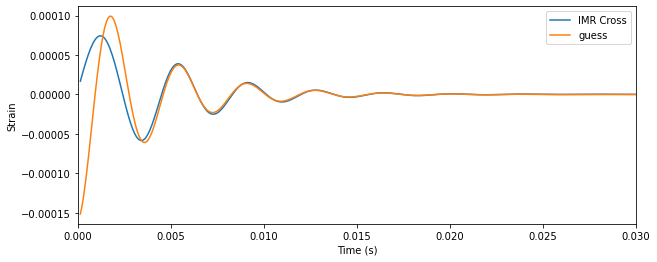

In [337]:
pylab.figure(figsize=pylab.figaspect(0.4))
surfin = rngdwn(time,62,0.68,2,2,0,1.6e-4,np.pi)
pylab.plot(cond, cond_hc, label='IMR Cross')
pylab.plot(surfin,label='guess')
pylab.xlim(0, 0.03)
#pylab.axvline(x=0.0085,linestyle='dashed') use this for 1e-18 and phi=0
#pylab.axvline(x=0.0115,linestyle='dashed')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
plt.savefig('hmfit_byeye')
#print(dir(signal))
#print(signal._values)

In [338]:
surfin_res = (surfin._values) - (cond_hc)

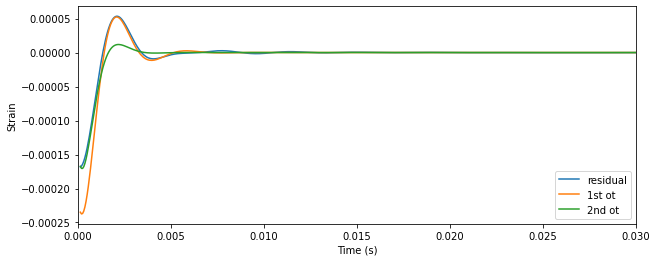

In [339]:
pylab.figure(figsize=pylab.figaspect(0.4))
surfin1 = rngdwn(time,62,0.68,2,2,1,3.1e-4,((3*np.pi)/4))
surfin2 = rngdwn(time,62,0.68,2,2,2,3e-4,((2*np.pi)/3))
pylab.plot(time,surfin_res,label='residual')
pylab.plot(surfin1,label='1st ot')
pylab.plot(surfin2,label='2nd ot')
pylab.xlim(0, 0.03)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
plt.savefig('hmfit_byeye_overtones')

In [340]:
def two_two_zero(time,M,chi,a220,phi220):
    #pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,0,2,2)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = a220,
    phi = phi220,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)

    return signal


def two_two_one(time,M,chi,a221,phi221):
    #pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,1,2,2)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = a221,
    phi = phi221,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)

    return signal


def two_two_two(time,M,chi,a222,phi222):
    #pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,2,2,2)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = a222,
    phi = phi222,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)

    return signal

In [341]:
#0th ot
xdata = time
ydata = cond_hc
p0 = [62,0.68,1e-4,np.pi]
popt,pcov = curve_fit(two_two_zero,xdata,ydata,p0,bounds=([50, .5, 1e-6, 0], [80, .85, 1e-3, 2*np.pi]))
#1st ot
xdata1 = time
ydata1 = cond_hc
p01 = [62,0.68,3e-4,np.pi]
popt1,pcov1 = curve_fit(two_two_one,xdata1,ydata1,p01,bounds=([50, .5, 1e-6, 0], [80, .85, 1e-3, 2*np.pi]))
#2nd ot
xdata2 = time
ydata2 = cond_hc
p02 = [62,0.68,1e-4,np.pi]
popt2,pcov2 = curve_fit(two_two_two,xdata2,ydata2,p02,bounds=([50, .5, 1e-6, 0], [80, .85, 1e-3, 2*np.pi]))



0th ot: 73.4514642974241 0.7286891803589289 0.00010821657393237653 4.4031562075478305
1st ot: 79.9977639305047 0.8199429496391096 0.00017619586206893916 4.375551362661414
2nd ot: 75.1655572928007 0.6523987174167678 0.00028221050954723695 4.480179632573433


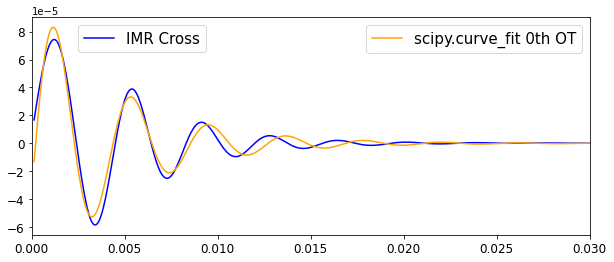

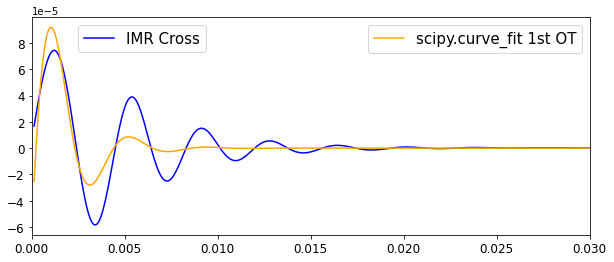

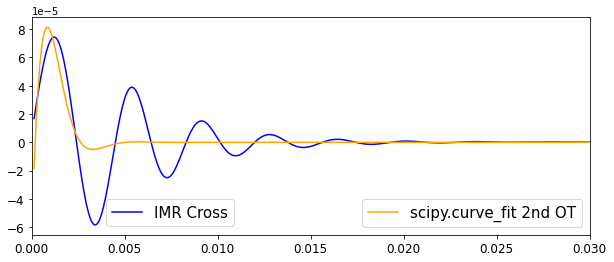

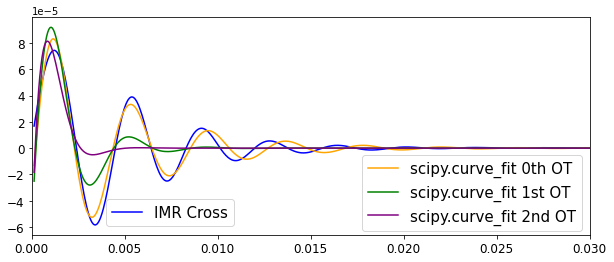

In [342]:
#0 ot
fig1, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twiny()
ax1.plot(cond, cond_hc, label='IMR Cross',c='blue')
ax2.plot(xdata, two_two_zero(xdata, *popt),label='scipy.curve_fit 0th OT',c='orange')
#
ax2.set_xlim(0,.03)
ax2.set_frame_on(False)                   # having to weirdly accomodate the axes
ax2.get_xaxis().tick_bottom()             # again
ax2.axes.get_xaxis().set_visible(False)   # remove top x axis
#
ax1.set_xlim(0,.03)
ax1.tick_params(axis='both',labelsize=12)
ax2.tick_params(axis='both',labelsize=12)
ax1.legend(bbox_to_anchor=(.07, 1),loc='upper left',fontsize=15)
ax2.legend(bbox_to_anchor=(1, 1),loc='upper right',fontsize=15)
fig1.savefig('curvefit',bbox_inches='tight')

#1 ot
fig1, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twiny()
ax1.plot(cond, cond_hc, label='IMR Cross',c='blue')
ax2.plot(xdata1, two_two_one(xdata1, *popt1),label='scipy.curve_fit 1st OT',c='orange')
#
ax2.set_xlim(0,.03)
ax2.set_frame_on(False)                   # having to weirdly accomodate the axes
ax2.get_xaxis().tick_bottom()             # again
ax2.axes.get_xaxis().set_visible(False)   # remove top x axis
#
ax1.set_xlim(0,.03)
ax1.tick_params(axis='both',labelsize=12)
ax2.tick_params(axis='both',labelsize=12)
ax1.legend(bbox_to_anchor=(.07, 1),loc='upper left',fontsize=15)
ax2.legend(bbox_to_anchor=(1, 1),loc='upper right',fontsize=15)
fig1.savefig('curvefit_1stOT',bbox_inches='tight')

#2 ot
fig1, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twiny()
ax1.plot(cond, cond_hc, label='IMR Cross',c='blue')
ax2.plot(xdata2, two_two_two(xdata2, *popt2),label='scipy.curve_fit 2nd OT',c='orange')
#
ax2.set_xlim(0,.03)
ax2.set_frame_on(False)                   # having to weirdly accomodate the axes
ax2.get_xaxis().tick_bottom()             # again
ax2.axes.get_xaxis().set_visible(False)   # remove top x axis
#
ax1.set_xlim(0,.03)
ax1.tick_params(axis='both',labelsize=12)
ax2.tick_params(axis='both',labelsize=12)
ax1.legend(bbox_to_anchor=(.12, .2),loc='upper left',fontsize=15)
ax2.legend(bbox_to_anchor=(1, .2),loc='upper right',fontsize=15)
fig1.savefig('curvefit_2ndOT',bbox_inches='tight')

#all overtones
fig1, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twiny()
ax1.plot(cond, cond_hc, label='IMR Cross',c='blue')
ax2.plot(xdata, two_two_zero(xdata, *popt),label='scipy.curve_fit 0th OT',c='orange')
ax2.plot(xdata1, two_two_one(xdata1, *popt1),label='scipy.curve_fit 1st OT',c='green')
ax2.plot(xdata2, two_two_two(xdata2, *popt2),label='scipy.curve_fit 2nd OT',c='purple')
#
ax2.set_xlim(0,.03)
ax2.set_frame_on(False)                   # having to weirdly accomodate the axes
ax2.get_xaxis().tick_bottom()             # again
ax2.axes.get_xaxis().set_visible(False)   # remove top x axis
#
ax1.set_xlim(0,.03)
ax1.tick_params(axis='both',labelsize=12)
ax2.tick_params(axis='both',labelsize=12)
ax1.legend(bbox_to_anchor=(.12, .2),loc='upper left',fontsize=15)
ax2.legend(bbox_to_anchor=(1, .4),loc='upper right',fontsize=15)
fig1.savefig('curvefit_012OT',bbox_inches='tight')


print('0th ot:',*popt)
print('1st ot:',*popt1)
print('2nd ot:',*popt2)

68.1926851720615 0.74779451970143 0.00013990252713049747 3.531880249991408 0.0001428272595512131 5.935530498985004 1.3211579408081876e-06 6.098621085302369


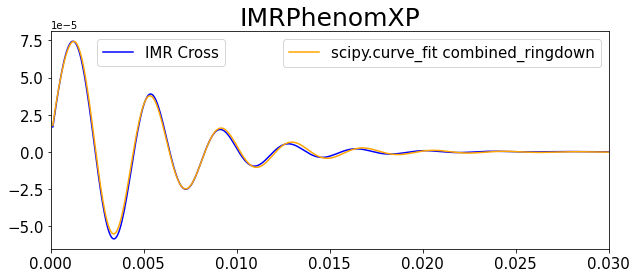

In [343]:
def combined_ringdown(time,M,chi,a220,phi220,a221,phi221,a222,phi222):
    comb = two_two_zero(time,M,chi,a220,phi220)+two_two_one(time,M,chi,a221,phi221)+two_two_two(time,M,chi,a222,phi222)
    return comb


xdata = time
ydata = cond_hc
p0 = [62,0.68,1e-4,np.pi]
popt,pcov = curve_fit(combined_ringdown,xdata,ydata,bounds=([50, .5, 1e-6, 0, 1e-6, 0, 1e-6, 0], [80, .85, 1e-3, 2*np.pi, 1e-3, 2*np.pi, 1e-3, 2*np.pi]))



fig1, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twiny()
ax1.plot(cond, cond_hc, label='IMR Cross',c='blue')
ax2.plot(xdata, combined_ringdown(xdata, *popt),label='scipy.curve_fit combined_ringdown',c='orange')
#
ax2.set_xlim(0,.03)
ax2.set_frame_on(False)                   # having to weirdly accomodate the axes
ax2.get_xaxis().tick_bottom()             # again
ax2.axes.get_xaxis().set_visible(False)   # remove top x axis
#
ax1.set_xlim(0,.03)
ax1.tick_params(axis='both',labelsize=15)
ax2.tick_params(axis='both',labelsize=15)
ax1.legend(bbox_to_anchor=(.07, 1),loc='upper left',fontsize=15)
ax2.legend(bbox_to_anchor=(1, 1),loc='upper right',fontsize=15)
ax1.set_title('IMRPhenomXP',fontsize=25)
fig1.savefig('attempt1',bbox_inches='tight')


print(*popt)

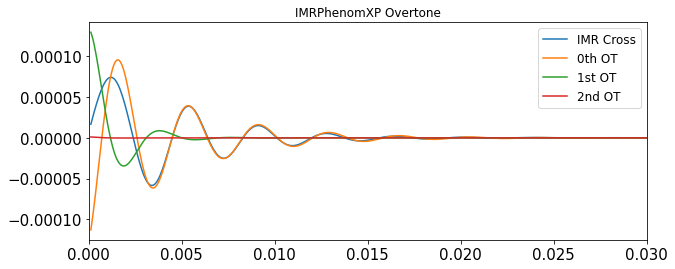

In [330]:
x = two_two_zero(time,68.0, 0.75, 1.4e-4, 3.53)
y = two_two_one(time,68.0, 0.75, 1.43e-4, 5.935)
z = two_two_two(time,68.0, 0.75, 1.32e-6, 6.1)
plt.figure(figsize=(10,4))
plt.plot(cond, cond_hc, label='IMR Cross')
plt.plot(x,label='0th OT')
plt.plot(y,label='1st OT')
plt.plot(z,label='2nd OT')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('IMRPhenomXP Overtone')
plt.xlim(0,.03)
plt.legend(fontsize=12)
plt.savefig('attempt_individual_ot')